In [2]:
from bacon.net import dataCreator
from bacon.stack import baconStack

In [3]:
stack = baconStack(size=4, baconType="poly2")

x, y = dataCreator.create(
    5000, 1, lambda x: (x[0] + x[1]) * x[2] + x[3] + x[4], params=5)
stack.fit(x, y)
m = stack.explain()
print(m.simplify(m.string(precision=2)))

ru + su + w + y


In [4]:
model = stack.get_model()
model.summary()

Model: "bacon-stack"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input 1 and 2 (InputLayer)     [(None, 2)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            49          ['input 1 and 2[0][0]']          
                                                                                                  
 input 3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['sequential[0][0]',             
                                                                  'input 3[0][0]']      

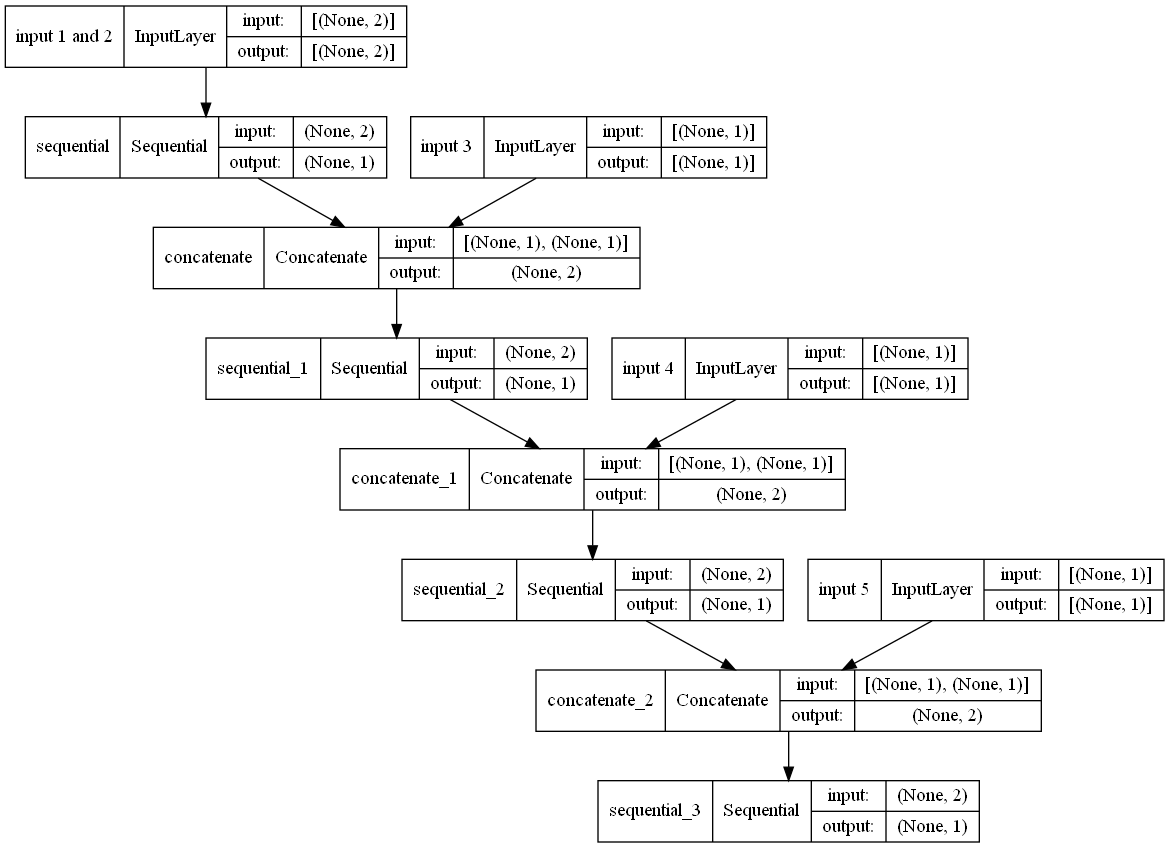

In [5]:
 from tensorflow.keras.utils import plot_model
 plot_model(model, "5-variable-stack.png", show_shapes=True)

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import copy
import time
from datetime import timedelta
from keras.layers import RepeatVector, Flatten

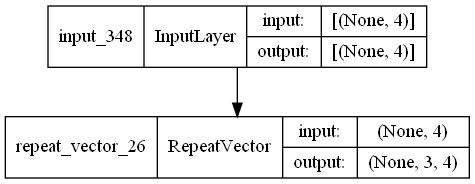

In [49]:
size = 3
parallel=3
models = []
for i in range(parallel):
    stack = baconStack(size=4, baconType="poly2")
    models.append(stack.get_model())

j = tf.keras.layers.Concatenate(models)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(size+1,)))
model.add(RepeatVector(parallel))
# model.add(Flatten())
# model.add(j)
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
plot_model(model, "parallel-3-stack.png", show_shapes=True)